In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Dict, List, Tuple


def extract_countries_and_values(
    file_name: str,
    countries: str,
    countries_list: list[str],  
    sex: str, 
    age: str, 
    choose: str, 
    age_column: str,
    age_value_life_expectancy: str,
    delimiter=',', 
    encoding='utf-8',
    chunk_size=10000
    ) -> dict[str, list[tuple[str, float]]]:

    result = {}

    try:
        for chunk in pd.read_csv(file_name, delimiter=delimiter, encoding=encoding, 
                                 usecols=[countries, sex, age, 'TIME_PERIOD', age_column],
                                 chunksize=chunk_size, on_bad_lines='skip'):

            period_data = [2020]
            chunk = chunk[chunk[countries].isin(countries_list)]
            chunk = chunk[chunk[age_column].isin(age_value_life_expectancy)]

            if choose:
                chunk = chunk[chunk[age].isin([choose])]

            chunk = chunk[chunk['TIME_PERIOD'].isin(period_data)]

            chunk[sex] = pd.to_numeric(chunk[sex], errors='coerce')
            
            if choose:
                chunk = chunk.drop_duplicates(subset=[countries, sex, age])
            else:
                chunk = chunk.drop_duplicates(subset=[countries, sex])
           
            chunk_result = (
                chunk.groupby([countries, age])  
                .agg({sex: 'first'})  
                .reset_index()  
            )

            for _, row in chunk_result.iterrows():
                country = row[countries]
                gender = row[age]
                value = row[sex]  

                if country not in result:
                    result[country] = [(gender, value)] 
                else:
                    result[country].append((gender, value))

        return result

    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found.")
        return {}
    except pd.errors.ParserError as e:
        print(f"Parsing error: {e}")
        return {}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}


def solve_data(result_l_female: dict[str, list[tuple[str, float]]], result_l_male: dict[str, list[tuple[str, float]]], result_s: dict[str, list[tuple[str, float]]]):
    countries = list(result_l_female.keys())
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'pink', 'purple']
    country_colors = {countries[i]: colors[i] for i in range(len(countries))}


    legend_handles_gender = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgray', markersize=10, label='Female'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='darkgray', markersize=10, label='Male')
    ]
    

    plt.figure(figsize=(9, 6))
    plt.xlabel('Life expectancy Above 65 years', fontsize=10)
    plt.ylabel('Smokers (%)', fontsize=10)
    plt.title('Scatter Plot of Life expectacy vs smokers')

    country_handles = []

    for country in countries:
        life_value_female = float(result_l_female[country][0][1])
        life_value_male = float(result_l_male[country][0][1])
        tabaco_value = result_s[country][0][1]
        plt.scatter(life_value_female, tabaco_value, color=country_colors[country], marker='o') 
        plt.scatter(life_value_male, tabaco_value, color=country_colors[country], marker='D')    

    country_handles = [Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=country) for country, color in country_colors.items()]
    all_handles = country_handles + legend_handles_gender

    plt.legend(handles=all_handles, title='Legend', loc='upper left', ncol=1, handleheight=1.4, labelspacing=0.7, fontsize=8)

    plt.tight_layout()
    plt.tight_layout()
    plt.show()

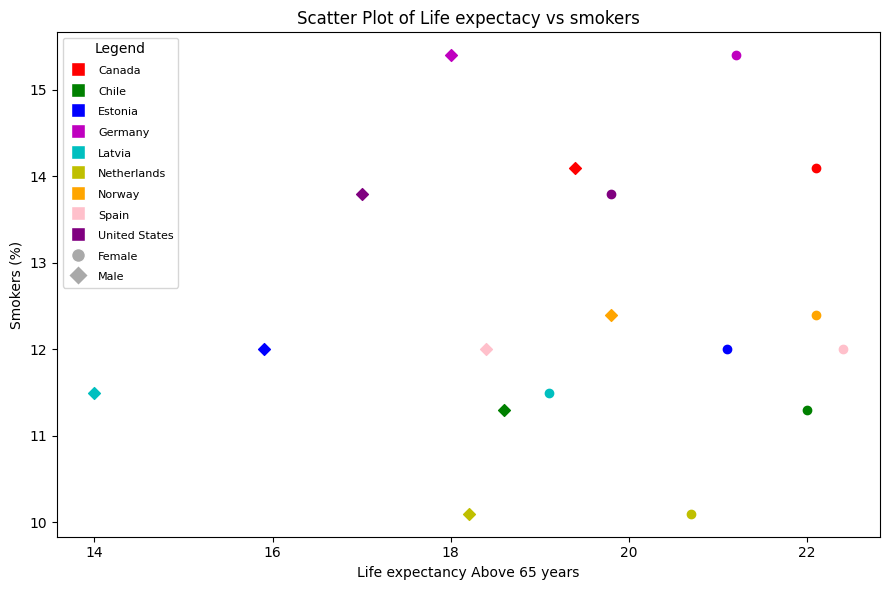

In [2]:
file_name_life_expectancy = './data/life_expectancy_unfiltered.csv'
file_name_tabaco_consumers = './data/tabaco_unfiltered.csv'

countries_list = ['Canada', 'Chile', 'Estonia', 'Germany', 'Latvia', 'Netherlands', 'Norway', 'Spain', 'United States']
age_value_life_expectancy = ['65 years']
age_value_tabaco_consumers = ['Total']

result_life_expectancy_female = extract_countries_and_values(file_name_life_expectancy, 'Reference area', countries_list, 'OBS_VALUE', 'Sex', 'Female', 'Age', age_value_life_expectancy, delimiter=',', encoding='utf-8')
result_life_expectancy_male = extract_countries_and_values(file_name_life_expectancy, 'Reference area', countries_list, 'OBS_VALUE', 'Sex', 'Male', 'Age', age_value_life_expectancy, delimiter=',', encoding='utf-8')
result_tabaco_consumers = extract_countries_and_values(file_name_tabaco_consumers, 'Reference area', countries_list, 'OBS_VALUE', 'Sex', 'Total', 'Age', age_value_tabaco_consumers,  delimiter=',', encoding='utf-8')

solve_data(result_life_expectancy_female, result_life_expectancy_male, result_tabaco_consumers)